<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Linear Regression

_Authors: Kevin Markham (DC), Ed Podojil (NYC)_

### Lesson Guide
- [Introduce the bikeshare data](#introduce-the-bikeshare-data)
	- [Reading in the data](#reading-in-the-data)
	- [Visualizing the data](#visualizing-the-data)
- [Linear regression basics](#linear-regression-basics)
	- [Form of linear regression](#form-of-linear-regression)
	- [Building a linear regression model](#building-a-linear-regression-model)
	- [Using the model for prediction](#using-the-model-for-prediction)
	- [Does the scale of the features matter?](#does-the-scale-of-the-features-matter)
- [Working with multiple features](#working-with-multiple-features)
	- [Visualizing the data (part 2)](#visualizing-the-data-part-)
	- [Adding more features to the model](#adding-more-features-to-the-model)
- [What is Multicollinearity?](#what-is-multicollinearity)
- [Choosing between models](#choosing-between-models)
	- [Feature selection](#feature-selection)
	- [Evaluation metrics for regression problems](#evaluation-metrics-for-regression-problems)
	- [Comparing models with train/test split and RMSE](#comparing-models-with-traintest-split-and-rmse)
	- [Comparing testing RMSE with null RMSE](#comparing-testing-rmse-with-null-rmse)
- [Creating features](#creating-features)
	- [Handling categorical features](#handling-categorical-features)
	- [Feature engineering](#feature-engineering)
- [Regularization](#regularization)
	- [How does regularization work?](#how-does-regularization-work)
	- [Lasso and ridge path diagrams](#lasso-and-ridge-path-diagrams)
	- [Advice for applying regularization](#advice-for-applying-regularization)
	- [Ridge regression](#ridge-regression)
- [Comparing linear regression with other models](#comparing-linear-regression-with-other-models)


In [58]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import Image
%matplotlib inline
plt.rcParams['figure.figsize'] = (8, 6)
plt.rcParams['font.size'] = 14
plt.style.use("fivethirtyeight")

<a id="introduce-the-bikeshare-data"></a>
## Introduce the bikeshare data

<a id="reading-in-the-data"></a>
<a id="reading-in-the-data"></a>
### Reading in the data

We'll be working with a dataset from Capital Bikeshare that was used in a Kaggle competition ([data dictionary](https://www.kaggle.com/c/bike-sharing-demand/data)).

In [4]:
# read the data and set the datetime as the index

url = 'https://raw.githubusercontent.com/justmarkham/DAT8/master/data/bikeshare.csv'
bikes = pd.read_csv(url, index_col='datetime', parse_dates=True)

In [5]:
bikes.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
datetime,,,,,,,,,,,
2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


**Questions:**

- What does each observation represent?
- What is the response variable (as defined by Kaggle)?
- How many features are there?

In [6]:
# "count" is a method, so it's best to name that column something else
bikes.rename(columns={'count':'total'}, inplace=True)

<a id="visualizing-the-data"></a>
<a id="visualizing-the-data"></a>
### Visualizing the data

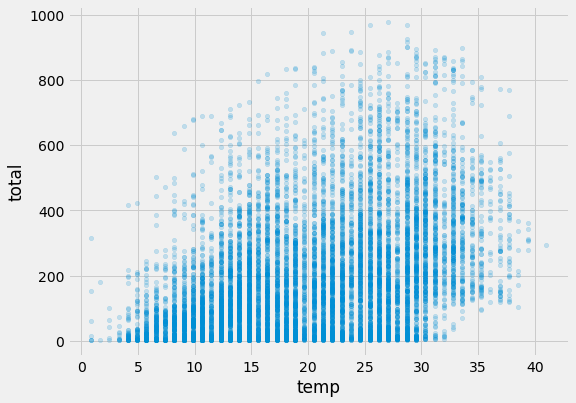

In [7]:
# Pandas scatter plot
bikes.plot(kind='scatter', x='temp', y='total', alpha=0.2);

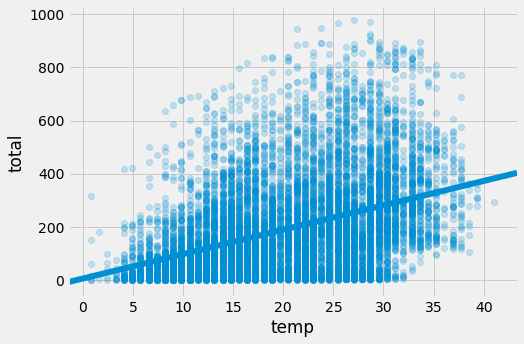

In [8]:
# Seaborn scatter plot with regression line
sns.lmplot(x='temp', y='total', data=bikes, aspect=1.5, scatter_kws={'alpha':0.2});

<a id="linear-regression-basics"></a>
## Linear regression basics

<a id="form-of-linear-regression"></a>
<a id="form-of-linear-regression"></a>
### Form of linear regression

$y = \alpha + \beta X + \epsilon$

$y = \beta_0 + \beta_1x_1 + \beta_2x_2 + ... + \beta_nx_n + \epsilon$

- $y$ is the response
- $\beta_0$ is the intercept
- $\beta_1$ is the coefficient for $x_1$ (the first feature)
- $\beta_n$ is the coefficient for $x_n$ (the nth feature)

The $\beta$ values are called the **model coefficients**:

- These values are estimated (or "learned") during the model fitting process using the **least squares criterion**.
- Specifically, we are find the line (mathematically) which minimizes the **sum of squared residuals** (or "sum of squared errors").
- And once we've learned these coefficients, we can use the model to predict the response.

In the diagram above:

- The black dots are the **observed values** of x and y.
- The blue line is our **least squares line**.
- The red lines are the **residuals**, which are the vertical distances between the observed values and the least squares line.

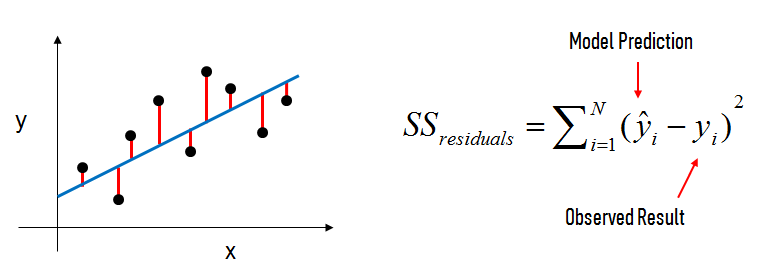

In [62]:
Image(r'../../assets/images/estimating_coefficients.png')

<a id="building-a-linear-regression-model"></a>
<a id="building-a-linear-regression-model"></a>
### Building a linear regression model

In [9]:
# create X and y
feature_cols = ['temp']
X = bikes[feature_cols]
y = bikes.total

In [10]:
# import, instantiate, fit
from sklearn.linear_model import LinearRegression
linreg = LinearRegression()
linreg.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [11]:
# print the coefficients
print(linreg.intercept_)
print(linreg.coef_)

6.046212959616781
[9.17054048]


Interpreting the **intercept** ($\beta_0$):

- It is the value of $y$ when $x$=0.
- Thus, it is the estimated number of rentals when the temperature is 0 degrees Celsius.
- **Note:** It does not always make sense to interpret the intercept. (Why?)

Interpreting the **"temp" coefficient** ($\beta_1$):

- It is the change in $y$ divided by change in $x$, or the "slope".
- Thus, a temperature increase of 1 degree Celsius is **associated with** a rental increase of 9.17 bikes.
- This is not a statement of causation.
- $\beta_1$ would be **negative** if an increase in temperature was associated with a **decrease** in rentals.

<a id="using-the-model-for-prediction"></a>
<a id="using-the-model-for-prediction"></a>
### Using the model for prediction

How many bike rentals would we predict if the temperature was 25 degrees Celsius?

In [12]:
# manually calculate the prediction
linreg.intercept_ + linreg.coef_*25

array([235.309725])

In [13]:
# use the predict method
linreg.predict(25)

array([235.309725])

<a id="does-the-scale-of-the-features-matter"></a>
<a id="does-the-scale-of-the-features-matter"></a>
### Does the scale of the features matter?

Let's say that temperature was measured in Fahrenheit, rather than Celsius. How would that affect the model?

In [14]:
# create a new column for Fahrenheit temperature
bikes['temp_F'] = bikes.temp * 1.8 + 32
bikes.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,total,temp_F
datetime,,,,,,,,,,,,
2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,49.712
2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,48.236
2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,48.236
2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,49.712
2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,49.712


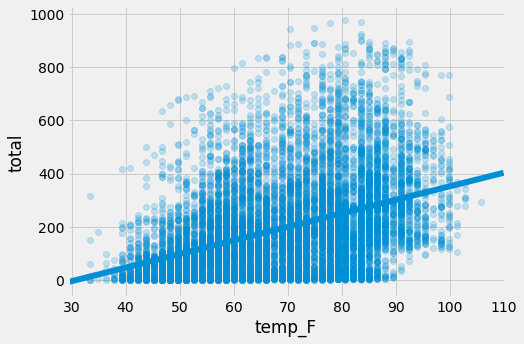

In [15]:
# Seaborn scatter plot with regression line
sns.lmplot(x='temp_F', y='total', data=bikes, aspect=1.5, scatter_kws={'alpha':0.2});

In [16]:
# create X and y
feature_cols = ['temp_F']
X = bikes[feature_cols]
y = bikes.total

# instantiate and fit
linreg = LinearRegression()
linreg.fit(X, y)

# print the coefficients
print(linreg.intercept_)
print(linreg.coef_)

-156.98561782129445
[5.09474471]


In [17]:
# convert 25 degrees Celsius to Fahrenheit
25 * 1.8 + 32

77.0

In [18]:
# predict rentals for 77 degrees Fahrenheit
linreg.predict(77)

array([235.309725])

**Conclusion:** The scale of the features is **irrelevant** for linear regression models. When changing the scale, we simply change our **interpretation** of the coefficients.

In [19]:
# remove the temp_F column
bikes.drop('temp_F', axis=1, inplace=True)

<a id="working-with-multiple-features"></a>
## Working with multiple features

<a id="visualizing-the-data-part-"></a>
<a id="visualizing-the-data-part-"></a>
### Visualizing the data (part 2)

In [20]:
# explore more features
feature_cols = ['temp', 'season', 'weather', 'humidity']

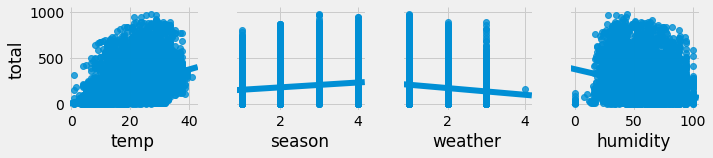

In [21]:
# multiple scatter plots in Seaborn
sns.pairplot(bikes, x_vars=feature_cols, y_vars='total', kind='reg');

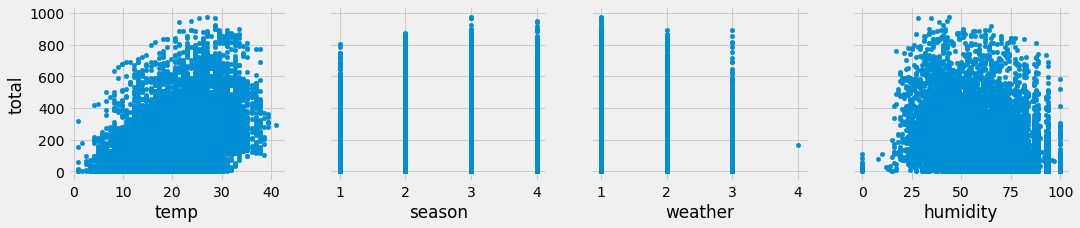

In [22]:
# multiple scatter plots in Pandas
fig, axs = plt.subplots(1, len(feature_cols), sharey=True)
for index, feature in enumerate(feature_cols):
    bikes.plot(kind='scatter', x=feature, y='total', ax=axs[index], figsize=(16, 3))

Are you seeing anything that you did not expect?

In [23]:
# cross-tabulation of season and month
pd.crosstab(bikes.season, bikes.index.month)

col_0,1,2,3,4,5,6,7,8,9,10,11,12
season,,,,,,,,,,,,
1,884,901,901,0,0,0,0,0,0,0,0,0
2,0,0,0,909,912,912,0,0,0,0,0,0
3,0,0,0,0,0,0,912,912,909,0,0,0
4,0,0,0,0,0,0,0,0,0,911,911,912


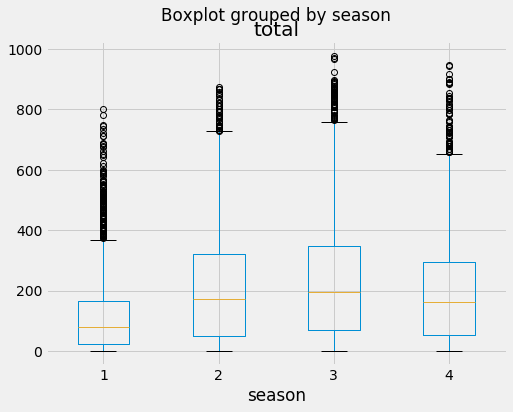

In [24]:
# box plot of rentals, grouped by season
bikes.boxplot(column='total', by='season');

Notably:

- A line can't capture a non-linear relationship.
- There are more rentals in winter than in spring (?)

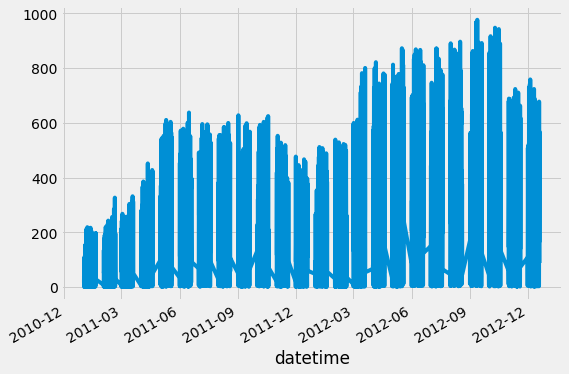

In [25]:
# line plot of rentals
bikes.total.plot();

What does this tell us?

There are more rentals in the winter than the spring, but only because the system is experiencing **overall growth** and the winter months happen to come after the spring months.

In [26]:
# correlation matrix (ranges from 1 to -1)
bikes.corr()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,total
season,1.000000,0.029368,-0.008126,0.008879,0.258689,0.264744,0.190610,-0.147121,0.096758,0.164011,0.163439
holiday,0.029368,1.000000,-0.250491,-0.007074,0.000295,-0.005215,0.001929,0.008409,0.043799,-0.020956,-0.005393
workingday,-0.008126,-0.250491,1.000000,0.033772,0.029966,0.024660,-0.010880,0.013373,-0.319111,0.119460,0.011594
weather,0.008879,-0.007074,0.033772,1.000000,-0.055035,-0.055376,0.406244,0.007261,-0.135918,-0.109340,-0.128655
temp,0.258689,0.000295,0.029966,-0.055035,1.000000,0.984948,-0.064949,-0.017852,0.467097,0.318571,0.394454
atemp,0.264744,-0.005215,0.024660,-0.055376,0.984948,1.000000,-0.043536,-0.057473,0.462067,0.314635,0.389784
humidity,0.190610,0.001929,-0.010880,0.406244,-0.064949,-0.043536,1.000000,-0.318607,-0.348187,-0.265458,-0.317371
windspeed,-0.147121,0.008409,0.013373,0.007261,-0.017852,-0.057473,-0.318607,1.000000,0.092276,0.091052,0.101369
casual,0.096758,0.043799,-0.319111,-0.135918,0.467097,0.462067,-0.348187,0.092276,1.000000,0.497250,0.690414
registered,0.164011,-0.020956,0.119460,-0.109340,0.318571,0.314635,-0.265458,0.091052,0.497250,1.000000,0.970948


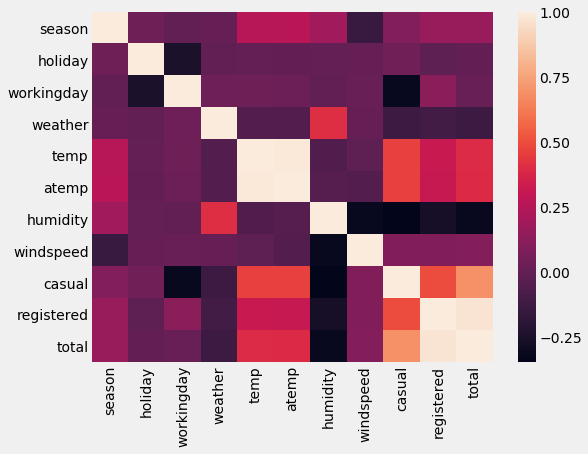

In [27]:
# visualize correlation matrix in Seaborn using a heatmap
sns.heatmap(bikes.corr())

What relationships do you notice?

<a id="adding-more-features-to-the-model"></a>
<a id="adding-more-features-to-the-model"></a>
### Adding more features to the model

In the previous example, one variable explained the variance of another; however, more often than not, we will need multiple variables. 

- For example, a house's price may be best measured by square feet, but a lot of other variables play a vital role: bedrooms, bathrooms, location, appliances, etc. 

- For a linear regression, we want these variables to be largely independent of each other, but all of them should help explain the y variable.

We'll work with bike-share data to showcase what this means and to explain a concept called multicollinearity.

In [28]:
# create a list of features
feature_cols = ['temp', 'season', 'weather', 'humidity']

In [29]:
# create X and y
X = bikes[feature_cols]
y = bikes.total

# instantiate and fit
linreg = LinearRegression()
linreg.fit(X, y)

# print the coefficients
print(linreg.intercept_)
print(linreg.coef_)

159.52068786129817
[ 7.86482499 22.53875753  6.67030204 -3.11887338]


In [30]:
# pair the feature names with the coefficients
list(zip(feature_cols, linreg.coef_))

[('temp', 7.864824992477439),
 ('season', 22.53875753246676),
 ('weather', 6.670302035923719),
 ('humidity', -3.118873382396501)]

Interpreting the coefficients:

- Holding all other features fixed, a 1 unit increase in **temperature** is associated with a **rental increase of 7.86 bikes**.
- Holding all other features fixed, a 1 unit increase in **season** is associated with a **rental increase of 22.5 bikes**.
- Holding all other features fixed, a 1 unit increase in **weather** is associated with a **rental increase of 6.67 bikes**.
- Holding all other features fixed, a 1 unit increase in **humidity** is associated with a **rental decrease of 3.12 bikes**.

Does anything look incorrect?

<a id="what-is-multicollinearity"></a>
<a id="what-is-multicollinearity"></a>
## What is Multicollinearity?

With the bike share data, let's compare three data points: actual temperature, "feel" temperature, and guest ridership.

            temp     atemp    casual
temp    1.000000  0.984948  0.467097
atemp   0.984948  1.000000  0.462067
casual  0.467097  0.462067  1.000000
AxesSubplot(0.08,0.07;0.696x0.81)


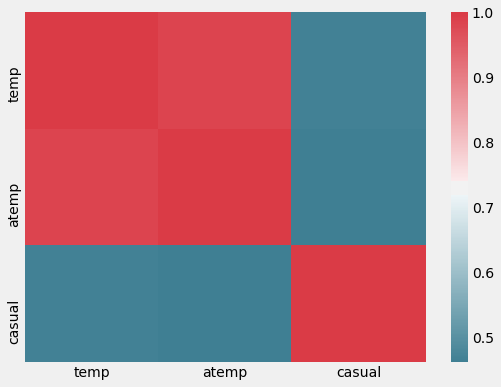

In [31]:
cmap = sns.diverging_palette(220, 10, as_cmap=True)
correlations = bikes[['temp', 'atemp', 'casual']].corr()
print(correlations)
print(sns.heatmap(correlations, cmap=cmap))

In [32]:
# create a list of features
feature_cols = ['temp', 'atemp']

In [33]:
# create X and y
X = bikes[feature_cols]
y = bikes.total

# instantiate and fit
linreg = LinearRegression()
linreg.fit(X, y)

# print the coefficients
print(linreg.intercept_)
print(linreg.coef_)

4.248132645803736
[8.19865874 0.90720808]


<a id="choosing-between-models"></a>
## Choosing between models

<a id="feature-selection"></a>
<a id="feature-selection"></a>
### Feature selection

How do we choose which features to include in the model? We're going to use **train/test split** (and eventually **cross-validation**).

Why not use of **p-values** or **R-squared** for feature selection?

- Linear models rely upon **a lot of assumptions** (such as the features being independent), and if those assumptions are violated, p-values and R-squared are less reliable. Train/test split relies on fewer assumptions.
- Features that are unrelated to the response can still have **significant p-values**.
- Adding features to your model that are unrelated to the response will always **increase the R-squared value**, and adjusted R-squared does not sufficiently account for this.
- p-values and R-squared are **proxies** for our goal of generalization, whereas train/test split and cross-validation attempt to **directly estimate** how well the model will generalize to out-of-sample data.

More generally:

- There are different methodologies that can be used for solving any given data science problem, and this course follows a **machine learning methodology**.
- This course focuses on **general purpose approaches** that can be applied to any model, rather than model-specific approaches.

<a id="evaluation-metrics-for-regression-problems"></a>
<a id="evaluation-metrics-for-regression-problems"></a>
### Evaluation metrics for regression problems

Evaluation metrics for classification problems, such as **accuracy**, are not useful for regression problems. We need evaluation metrics designed for comparing **continuous values**.

Here are three common evaluation metrics for regression problems:

**Mean Absolute Error** (MAE) is the mean of the absolute value of the errors:

$$\frac 1n\sum_{i=1}^n|y_i-\hat{y}_i|$$

**Mean Squared Error** (MSE) is the mean of the squared errors:

$$\frac 1n\sum_{i=1}^n(y_i-\hat{y}_i)^2$$

**Root Mean Squared Error** (RMSE) is the square root of the mean of the squared errors:

$$\sqrt{\frac 1n\sum_{i=1}^n(y_i-\hat{y}_i)^2}$$

In [34]:
# example true and predicted response values
true = [10, 7, 5, 5]
pred = [8, 6, 5, 10]

In [35]:
# calculate these metrics by hand!
from sklearn import metrics
import numpy as np
print('MAE:', metrics.mean_absolute_error(true, pred))
print('MSE:', metrics.mean_squared_error(true, pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(true, pred)))

MAE: 2.0
MSE: 7.5
RMSE: 2.7386127875258306


Comparing these metrics:

- **MAE** is the easiest to understand, because it's the average error.
- **MSE** is more popular than MAE, because MSE "punishes" larger errors, which tends to be useful in the real world.
- **RMSE** is even more popular than MSE, because RMSE is interpretable in the "y" units.

All of these are **loss functions**, because we want to minimize them.

Here's an additional example, to demonstrate how MSE/RMSE punish larger errors:

In [36]:
# same true values as above
true = [10, 7, 5, 5]

# new set of predicted values
pred = [10, 7, 5, 13]

# MAE is the same as before
print('MAE:', metrics.mean_absolute_error(true, pred))

# MSE and RMSE are larger than before
print('MSE:', metrics.mean_squared_error(true, pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(true, pred)))

MAE: 2.0
MSE: 16.0
RMSE: 4.0


<a id="comparing-models-with-traintest-split-and-rmse"></a>
<a id="comparing-models-with-traintest-split-and-rmse"></a>
### Comparing models with train/test split and RMSE

In [37]:
from sklearn.model_selection import train_test_split

# define a function that accepts a list of features and returns testing RMSE
def train_test_rmse(feature_cols):
    X = bikes[feature_cols]
    y = bikes.total
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=123)
    linreg = LinearRegression()
    linreg.fit(X_train, y_train)
    y_pred = linreg.predict(X_test)
    
    return np.sqrt(metrics.mean_squared_error(y_test, y_pred))

In [38]:
# compare different sets of features
print(train_test_rmse(['temp', 'season', 'weather', 'humidity']))
print(train_test_rmse(['temp', 'season', 'weather']))
print(train_test_rmse(['temp', 'season', 'humidity']))

155.64945913079674
164.1653997629182
155.59818936691417


### Exercise

Try out as many combinations of features as you can to evaluate train_test_rmse

Tips:
- look at the combinations package in itertools: https://docs.python.org/2/library/itertools.html#itertools.combinations
- think about if there are any features you should not include

In [39]:
from itertools import combinations

features = [col for col in bikes.columns if col not in (['total','casual','registered'])]

results = []
for i in range(1,len(features)):
    for feature_combo in combinations(features, i):
        rmse = train_test_rmse(list(feature_combo))
        results.append([feature_combo, rmse])
    
result = pd.DataFrame(results, columns=['features','rmse']).sort_values('rmse')
result.head()

,features,rmse
196,"(season, temp, atemp, humidity, windspeed)",155.368721
237,"(season, workingday, temp, atemp, humidity, wi...",155.371790
250,"(season, holiday, workingday, temp, atemp, hum...",155.387891
232,"(season, holiday, temp, atemp, humidity, winds...",155.388845
126,"(season, atemp, humidity, windspeed)",155.407628


<a id="comparing-testing-rmse-with-null-rmse"></a>
<a id="comparing-testing-rmse-with-null-rmse"></a>
### Comparing testing RMSE with null RMSE

Null RMSE is the RMSE that could be achieved by **always predicting the mean response value**. It is a benchmark against which you may want to measure your regression model.

In [40]:
# using these as features is not allowed!
print(train_test_rmse(['casual', 'registered']))

6.465079976076669e-14


In [41]:
# split X and y into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=123)

# create a NumPy array with the same shape as y_test
y_null = np.zeros_like(y_test, dtype=float)

# fill the array with the mean value of y_test
y_null.fill(y_test.mean())
y_null

array([192.26451139, 192.26451139, 192.26451139, ..., 192.26451139,
       192.26451139, 192.26451139])

In [42]:
# compute null RMSE
np.sqrt(metrics.mean_squared_error(y_test, y_null))

179.57906896465727

<a id="creating-features"></a>
## Creating features

<a id="handling-categorical-features"></a>
<a id="handling-categorical-features"></a>
### Handling categorical features

scikit-learn expects all features to be numeric. So how do we include a categorical feature in our model?

- **Ordered categories:** transform them to sensible numeric values (example: small=1, medium=2, large=3)
- **Unordered categories:** use dummy encoding (0/1)

What are the categorical features in our dataset?

- **Ordered categories:** weather (already encoded with sensible numeric values)
- **Unordered categories:** season (needs dummy encoding), holiday (already dummy encoded), workingday (already dummy encoded)

For season, we can't simply leave the encoding as 1 = spring, 2 = summer, 3 = fall, and 4 = winter, because that would imply an **ordered relationship**. Instead, we create **multiple dummy variables:**

In [43]:
# create dummy variables
season_dummies = pd.get_dummies(bikes.season, prefix='season')

# print 5 random rows
season_dummies.sample(n=5, random_state=1)

,season_1,season_2,season_3,season_4
datetime,,,,
2011-09-05 11:00:00,0,0,1,0
2012-03-18 04:00:00,1,0,0,0
2012-10-14 17:00:00,0,0,0,1
2011-04-04 15:00:00,0,1,0,0
2012-12-11 02:00:00,0,0,0,1


However, we actually only need **three dummy variables (not four)**, and thus we'll drop the first dummy variable.

Why? Because three dummies captures all of the "information" about the season feature, and implicitly defines spring (season 1) as the **baseline level:**

In [44]:
# drop the first column
season_dummies.drop(season_dummies.columns[0], axis=1, inplace=True)

# print 5 random rows
season_dummies.sample(n=5, random_state=1)

,season_2,season_3,season_4
datetime,,,
2011-09-05 11:00:00,0,1,0
2012-03-18 04:00:00,0,0,0
2012-10-14 17:00:00,0,0,1
2011-04-04 15:00:00,1,0,0
2012-12-11 02:00:00,0,0,1


In general, if you have a categorical feature with **k possible values**, you create **k-1 dummy variables**.

If that's confusing, think about why we only need one dummy variable for holiday, not two dummy variables (holiday_yes and holiday_no).

In [45]:
# concatenate the original DataFrame and the dummy DataFrame (axis=0 means rows, axis=1 means columns)
bikes = pd.concat([bikes, season_dummies], axis=1)

# print 5 random rows
bikes.sample(n=5, random_state=1)

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,total,season_2,season_3,season_4
datetime,,,,,,,,,,,,,,
2011-09-05 11:00:00,3,1,0,2,28.70,33.335,74,11.0014,101,207,308,0,1,0
2012-03-18 04:00:00,1,0,0,2,17.22,21.210,94,11.0014,6,8,14,0,0,0
2012-10-14 17:00:00,4,0,0,1,26.24,31.060,44,12.9980,193,346,539,0,0,1
2011-04-04 15:00:00,2,0,1,1,31.16,33.335,23,36.9974,47,96,143,1,0,0
2012-12-11 02:00:00,4,0,1,2,16.40,20.455,66,22.0028,0,1,1,0,0,1


In [46]:
# include dummy variables for season in the model
feature_cols = ['temp', 'season_2', 'season_3', 'season_4', 'humidity']
X = bikes[feature_cols]
y = bikes.total
linreg = LinearRegression()
linreg.fit(X, y)
list(zip(feature_cols, linreg.coef_))

[('temp', 11.186405863575784),
 ('season_2', -3.3905430997179598),
 ('season_3', -41.73686071317068),
 ('season_4', 64.41596146824214),
 ('humidity', -2.819481636259646)]

How do we interpret the season coefficients? They are **measured against the baseline (spring)**:

- Holding all other features fixed, **summer** is associated with a **rental decrease of 3.39 bikes** compared to the spring.
- Holding all other features fixed, **fall** is associated with a **rental decrease of 41.7 bikes** compared to the spring.
- Holding all other features fixed, **winter** is associated with a **rental increase of 64.4 bikes** compared to the spring.

Would it matter if we changed which season was defined as the baseline?

- No, it would simply change our **interpretation** of the coefficients.

**Important:** Dummy encoding is relevant for all machine learning models, not just linear regression models.

In [47]:
# compare original season variable with dummy variables
print(train_test_rmse(['temp', 'season', 'humidity']))
print(train_test_rmse(['temp', 'season_2', 'season_3', 'season_4', 'humidity']))

155.59818936691417
154.33394593635998


<a id="feature-engineering"></a>
<a id="feature-engineering"></a>
### Feature engineering

See if you can create the following features:

- **hour:** as a single numeric feature (0 through 23)
- **hour:** as a categorical feature (use 23 dummy variables)
- **daytime:** as a single categorical feature (daytime=1 from 7am to 8pm, and daytime=0 otherwise)

Then, try using each of the three features (on its own) with `train_test_rmse` to see which one performs the best!

In [48]:
# hour as a numeric feature (look at the index)
bikes['hour'] = bikes.index.hour

In [49]:
# hour as a categorical feature
hour_dummies = pd.get_dummies(bikes.hour, prefix='hour')
hour_dummies.drop(hour_dummies.columns[0], axis=1, inplace=True)
bikes = pd.concat([bikes, hour_dummies], axis=1)

In [50]:
# daytime as a categorical feature
bikes['daytime'] = ((bikes.hour > 6) & (bikes.hour < 21)).astype(int)

In [51]:
print(train_test_rmse(['hour']))
print(train_test_rmse(bikes.columns[bikes.columns.str.startswith('hour_')]))
print(train_test_rmse(['daytime']))

165.67174264111398
128.3112050281119
144.89116360237938


<a id="regularization"></a>
## Regularization

- Regularization is a method for "constraining" or "regularizing" the **size of the coefficients**, thus "shrinking" them towards zero.
- It reduces model variance and thus **minimizes overfitting**.
- If the model is too complex, it tends to reduce variance more than it increases bias, resulting in a model that is **more likely to generalize**.

Our goal is to locate the **optimum model complexity**, and thus regularization is useful when we believe our model is too complex.

<a id="how-does-regularization-work"></a>
<a id="how-does-regularization-work"></a>
### How does regularization work?

For a normal linear regression model, we estimate the coefficients using the least squares criterion, which **minimizes the residual sum of squares (RSS):**

For a regularized linear regression model, we **minimize the sum of RSS and a "penalty term"** that penalizes coefficient size.

**Ridge regression** (or "L2 regularization") minimizes: $$\text{RSS} + \alpha \sum_{j=1}^p \beta_j^2$$

**Lasso regression** (or "L1 regularization") minimizes: $$\text{RSS} + \alpha \sum_{j=1}^p |\beta_j|$$

- $p$ is the **number of features**
- $\beta_j$ is a **model coefficient**
- $\alpha$ is a **tuning parameter:**
    - A tiny $\alpha$ imposes no penalty on the coefficient size, and is equivalent to a normal linear regression model.
    - Increasing the $\alpha$ penalizes the coefficients and thus shrinks them.

<a id="lasso-and-ridge-path-diagrams"></a>
<a id="lasso-and-ridge-path-diagrams"></a>
### Lasso and ridge path diagrams

A larger alpha (towards the left of each diagram) results in more regularization:

- **Lasso regression** shrinks coefficients all the way to zero, thus removing them from the model
- **Ridge regression** shrinks coefficients toward zero, but they rarely reach zero

Source code for the diagrams: [Lasso regression](http://scikit-learn.org/stable/auto_examples/linear_model/plot_lasso_lars.html) and [Ridge regression](http://scikit-learn.org/stable/auto_examples/linear_model/plot_ridge_path.html)

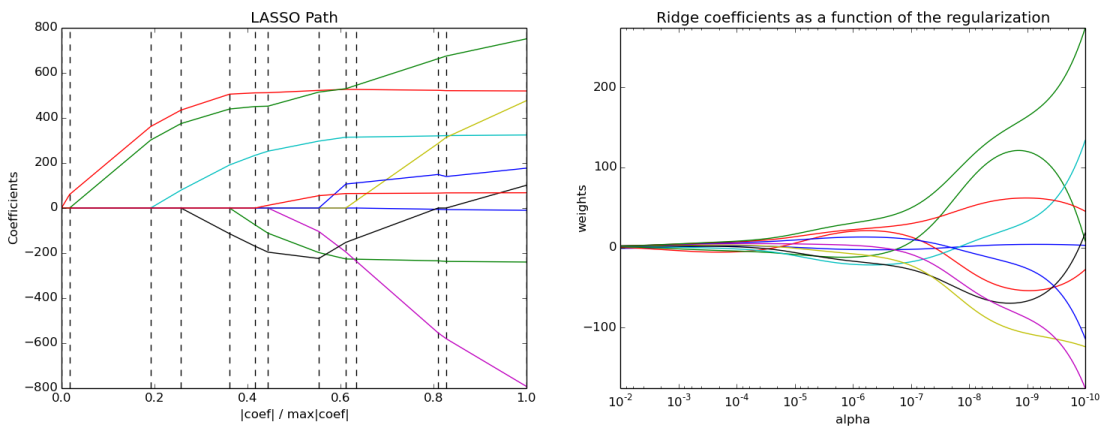

In [65]:
Image(r'../../assets/images/lasso_ridge_path.png')

<a id="advice-for-applying-regularization"></a>
<a id="advice-for-applying-regularization"></a>
### Advice for applying regularization

**Should features be standardized?**

- Yes, because otherwise, features would be penalized simply because of their scale.
- Also, standardizing avoids penalizing the intercept, which wouldn't make intuitive sense.

**How should you choose between Lasso regression and Ridge regression?**

- Lasso regression is preferred if we believe many features are irrelevant or if we prefer a sparse model.
- Ridge can work particularly well if there is a high degree of multicolinearity in your model.
- If model performance is your primary concern, it is best to try both.
- ElasticNet regression is a combination of lasso regression and ridge Regression.

<a id="ridge-regression"></a>
<a id="ridge-regression"></a>
### Ridge regression

- [Ridge](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html) documentation
- **alpha:** must be positive, increase for more regularization
- **normalize:** scales the features (without using StandardScaler)

In [66]:
# include dummy variables for season in the model
feature_cols = ['temp', 'atemp', 'season_2', 'season_3', 'season_4', 'humidity']
X = bikes[feature_cols]
y = bikes.total

In [67]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

In [68]:
from sklearn.linear_model import Ridge

# build a ridge regression
ridgereg = Ridge(alpha=0, normalize=True)  # alpha=0 is equivalent to linear regression
ridgereg.fit(X_train, y_train)
y_pred = ridgereg.predict(X_test)

print(np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

156.67429349903927


In [69]:
list(zip(feature_cols, ridgereg.coef_))

[('temp', 8.5375309025936),
 ('atemp', 2.454854098756152),
 ('season_2', -9.325429567785932),
 ('season_3', -40.67899619746481),
 ('season_4', 61.11748928364946),
 ('humidity', -2.865044830544153)]

To interpret these coefficients we need to convert them back to original units, which is a reason to do normalization by hand. However, in this form the coefficients have a special meaning. The intercept is now the average of our outcome, and the magnitude of each coefficient in the model is a measure of how important it is in the model. We call this feature importance.

In [70]:
# try alpha=0.1
ridgereg = Ridge(alpha=0.1, normalize=True)
ridgereg.fit(X_train, y_train)
y_pred = ridgereg.predict(X_test)
print(np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

156.96098662565274


In [57]:
# examine the coefficients
list(zip(feature_cols, ridgereg.coef_))

[('temp', 5.257452659873024),
 ('atemp', 4.254523291538832),
 ('season_2', -0.17934556275241303),
 ('season_3', -21.483942605445247),
 ('season_4', 56.682207841866706),
 ('humidity', -2.658837791464091)]

### Lasso Regression

- [Lasso](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html) documentation
- **alpha:** must be positive, increase for more regularization
- **normalize:** scales the features (without using StandardScaler)

In [79]:
# alpha=0 is equivalent to linear regression
from sklearn.linear_model import Lasso
lasso = Lasso(alpha=1e-10, normalize=True)  # 1e-10 ~= 0
lasso.fit(X_train, y_train)
y_pred = lasso.predict(X_test)
print(np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

156.67429349807836


In [80]:
list(zip(feature_cols, lasso.coef_))

[('temp', 8.537530972893704),
 ('atemp', 2.454854034438654),
 ('season_2', -9.325429532884359),
 ('season_3', -40.67899620664376),
 ('season_4', 61.117489293055606),
 ('humidity', -2.8650448294790354)]

In [105]:
# try alpha=0.1
lasso = Lasso(alpha=.01, normalize=True)
lasso.fit(X_train, y_train)
y_pred = lasso.predict(X_test)
print(np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

156.67657688258208


In [107]:
list(zip(feature_cols, lasso.coef_))

[('temp', 7.803871110135114),
 ('atemp', 2.519733330683213),
 ('season_2', -0.0),
 ('season_3', -27.102723882585845),
 ('season_4', 63.42614680497853),
 ('humidity', -2.8568550955633376)]

<a id="comparing-linear-regression-with-other-models"></a>
<a id="comparing-linear-regression-with-other-models"></a>
## Comparing linear regression with other models

Advantages of linear regression:

- Simple to explain
- Highly interpretable
- Model training and prediction are fast
- No tuning is required (excluding regularization)
- Features don't need scaling
- Can perform well with a small number of observations
- Well-understood

Disadvantages of linear regression:

- Presumes a linear relationship between the features and the response
- Performance is (generally) not competitive with the best supervised learning methods due to high bias
- Can't automatically learn feature interactions